# Stroke Models & Analysis

In [1]:
#Import DataFrame from Data-Cleaning-Notebook
import pickle
import pandas as pd
import numpy as np
infile = open('pickled_files/df.pickle','rb')
df = pickle.load(infile)
infile.close()


In [2]:
from sklearn.metrics import classification_report, plot_confusion_matrix, recall_score

In [3]:
def evaluation_report(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))
    plot_confusion_matrix(model, X, y, cmap='GnBu')


In [4]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi_cat
0,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked,1,obese
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked,1,unknown
2,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked,1,obese
3,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes,1,obese
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked,1,normal


In [5]:
from sklearn.model_selection import train_test_split
X = df.drop(['stroke'], axis = 1)
y = df.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Model 1 - First Simple Model

Do a dummy classifier for our first simple model to compare our future models to.

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# setting up testing and training sets

In [7]:
df.stroke.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [8]:
# DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

In [9]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred))

Test Accuracy score:  0.9374021909233177


In [10]:
# checking recall
print('Test Recall score: ', recall_score(y_test, dummy_pred))

Test Recall score:  0.0


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.00      0.00      0.00        80

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.88      0.94      0.91      1278



/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


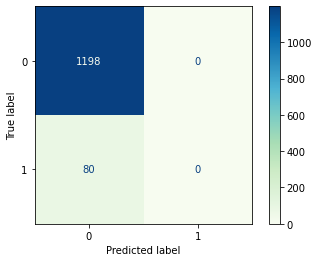

In [11]:
evaluation_report(dummy, X_test, y_test)

#### Model 2 - Logistic Regression: No Penalty / Without Oversampling

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3831 entries, 4000 to 860
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3831 non-null   object 
 1   age                3831 non-null   float64
 2   hypertension       3831 non-null   int64  
 3   heart_disease      3831 non-null   int64  
 4   ever_married       3831 non-null   object 
 5   work_type          3831 non-null   object 
 6   Residence_type     3831 non-null   object 
 7   avg_glucose_level  3831 non-null   float64
 8   smoking_status     3831 non-null   object 
 9   bmi_cat            3831 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 329.2+ KB


In [14]:
X_train_nums = X_train.select_dtypes(['float64'])
X_train_cat = X_train.select_dtypes(exclude = ['float64'])

In [15]:
from sklearn.compose import ColumnTransformer

In [16]:
numerical_pipeline = Pipeline(steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = Pipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False))
                            ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

log_reg_no_pen_pipe = Pipeline(steps=[
    ('trans', trans),
    ('lr', LogisticRegression(penalty = 'none', max_iter = 1000))
])

In [17]:
log_reg_no_pen_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('lr', LogisticRegression(max_iter=1000, penalty='none'))])

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       0.20      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.57      0.50      0.49      1278
weighted avg       0.89      0.94      0.91      1278



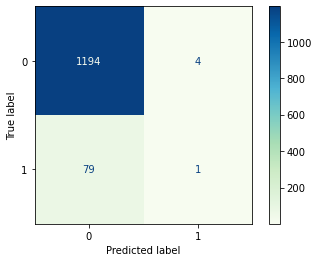

In [18]:
evaluation_report(log_reg_no_pen_pipe, X_test, y_test)

YIKES

#### Model 3 - Over sample then Logistic Regression

In [19]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [20]:
numerical_pipeline = imbpipeline(steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = imbpipeline(steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False))
                            ])

trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_nums.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [21]:
log_reg_scaled_pipe = imbpipeline(steps=[
    ('trans', trans),
    ('sm', SMOTE()),
    ('lr', LogisticRegression(max_iter = 10000))
])

In [22]:
log_reg_scaled_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('sm', SMOTE()), ('lr', LogisticRegression(max_iter=10000))])

In [23]:
log_reg_scaled_pipe.score(X_train, y_train)

0.7663795353693552

In [24]:
recall_score(y_test, log_reg_scaled_pipe.predict(X_test))

0.725

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1198
           1       0.16      0.72      0.27        80

    accuracy                           0.75      1278
   macro avg       0.57      0.74      0.56      1278
weighted avg       0.93      0.75      0.81      1278



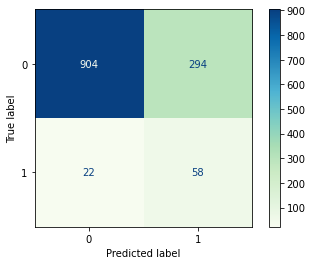

In [25]:
evaluation_report(log_reg_scaled_pipe, X_test, y_test)

#### Model 4 - Logistic Regression with Polynomial Features

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
from sklearn.feature_selection import SelectKBest

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1198
           1       0.17      0.40      0.24        80

    accuracy                           0.84      1278
   macro avg       0.56      0.64      0.58      1278
weighted avg       0.91      0.84      0.87      1278



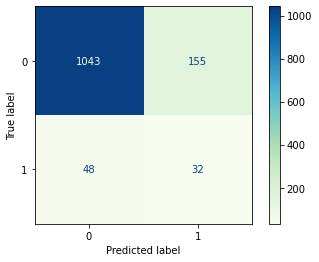

In [28]:
logreg_poly2_pipe = imbpipeline(steps=[
    ('trans', trans),
    ('sm', SMOTE()),
    ('pf', PolynomialFeatures(2, include_bias = False)),
    ('lr', LogisticRegression(max_iter = 10000))
])

logreg_poly2_pipe.fit(X_train, y_train)
evaluation_report(logreg_poly2_pipe, X_test, y_test)

Alrighty, we didn't want polynomial features anyways

#### Model 5 - Voting Classifier with LogReg/DT/KNN

In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [30]:
steps=[ ('trans', trans),
        ('sm', SMOTE()),
        ('vc',VotingClassifier(
                estimators=[('logreg', LogisticRegression(max_iter = 10000)), 
                            ('knneighbors', KNeighborsClassifier()), 
                            ('decisiontree', DecisionTreeClassifier())], 
                voting='hard'))]
vc_pipe = imbpipeline(steps = steps)

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1198
           1       0.20      0.47      0.28        80

    accuracy                           0.85      1278
   macro avg       0.58      0.67      0.60      1278
weighted avg       0.91      0.85      0.87      1278



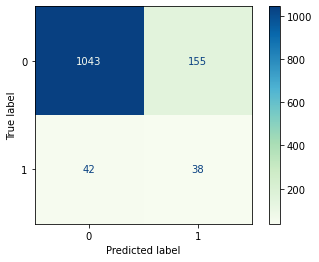

In [31]:
vc_pipe.fit(X_train, y_train)
evaluation_report(vc_pipe, X_test, y_test)

#### Model 6 - GridSearchCV: KNN

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('clf', KNeighborsClassifier())]

knn_cv_pipe = imbpipeline(steps=steps)

parameters = {
    'clf__n_neighbors': range(10, 200, 10),
    'clf__metric': ['minkowski', 'manhattan'],
    'clf__weights': ['uniform', 'distance'],
}

cv = GridSearchCV(knn_cv_pipe, param_grid=parameters, scoring='recall')
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

              precision    recall  f1-score   support

           0       0.99      0.69      0.81      3662
           1       0.12      0.89      0.21       169

    accuracy                           0.70      3831
   macro avg       0.55      0.79      0.51      3831
weighted avg       0.95      0.70      0.79      3831



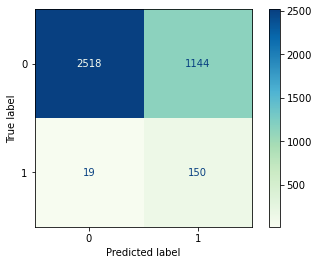

In [34]:
evaluation_report(cv.best_estimator_, X_train, y_train)

              precision    recall  f1-score   support

           0       0.98      0.69      0.81      1198
           1       0.15      0.79      0.25        80

    accuracy                           0.70      1278
   macro avg       0.56      0.74      0.53      1278
weighted avg       0.93      0.70      0.78      1278



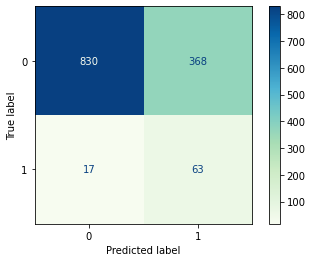

In [35]:
evaluation_report(cv, X_test, y_test)

#### Model 7 - Bagging Classifier

In [36]:
from sklearn.ensemble import BaggingClassifier

In [37]:
BaggingClassifier().get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [38]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('bag', BaggingClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced'), 
            n_estimators= 100,
            max_samples= 0.8,
            max_features= 7,
            oob_score= True
                ))]
bag_pipe = imbpipeline(steps=steps)
bag_pipe.fit(X_train, y_train)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status', 'bmi_cat'],
      dtype='object'))])),
                ('sm', SMOTE()),
                ('bag',
                 BaggingClassifier(base_estim

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1198
           1       0.22      0.61      0.33        80

    accuracy                           0.84      1278
   macro avg       0.60      0.74      0.62      1278
weighted avg       0.92      0.84      0.87      1278



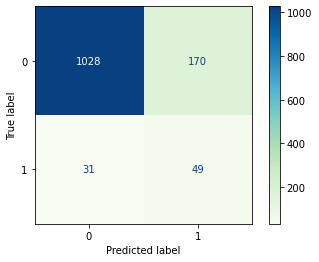

In [39]:
evaluation_report(bag_pipe, X_test, y_test)

#### Model 8 - Bagging + Gridsearch

In [40]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced'), verbose = 1))]

bag_pipe = imbpipeline(steps=steps)
params = {
    'bag__n_estimators': range(10,50,10),
    'bag__max_samples': [.3,.4,.5,.6,.7,.8],
    'bag__max_features': [1,18,1]
}
cv_bag = GridSearchCV(bag_pipe, param_grid=params, scoring='recall')
cv_bag.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

In [41]:
cv_bag.best_params_

{'bag__max_features': 18, 'bag__max_samples': 0.3, 'bag__n_estimators': 30}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3662
           1       0.16      0.85      0.26       169

    accuracy                           0.79      3831
   macro avg       0.57      0.82      0.57      3831
weighted avg       0.95      0.79      0.85      3831



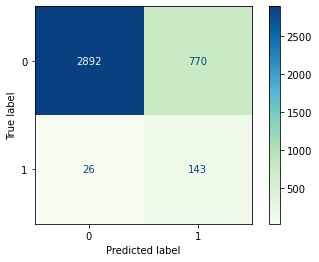

In [42]:
evaluation_report(cv_bag, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1198
           1       0.18      0.72      0.29        80

    accuracy                           0.78      1278
   macro avg       0.58      0.75      0.58      1278
weighted avg       0.93      0.78      0.83      1278



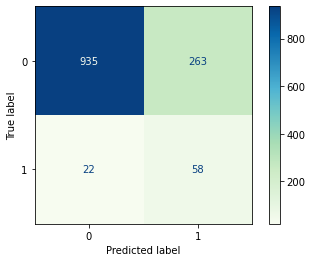

In [43]:
evaluation_report(cv_bag, X_test, y_test)

#### Model 9 - 

In [44]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced'), verbose = 1))]

bag_pipe = imbpipeline(steps=steps)
params = {
    'bag__n_estimators': range(10,20,1),
    'bag__max_samples': [.8,.85,.9,.95],
    'bag__max_features': [18],
    'bag__base_estimator__max_depth':[2,3,4]
}
cv_bag = GridSearchCV(bag_pipe, param_grid=params, scoring='precision')
cv_bag.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

In [45]:
cv_bag.best_params_

{'bag__base_estimator__max_depth': 4,
 'bag__max_features': 18,
 'bag__max_samples': 0.9,
 'bag__n_estimators': 19}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.99      0.77      0.87      3662
           1       0.15      0.84      0.25       169

    accuracy                           0.78      3831
   macro avg       0.57      0.81      0.56      3831
weighted avg       0.95      0.78      0.84      3831



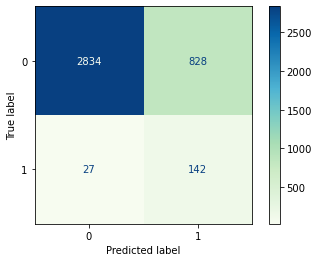

In [46]:
evaluation_report(cv_bag, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1198
           1       0.17      0.71      0.28        80

    accuracy                           0.77      1278
   macro avg       0.57      0.74      0.57      1278
weighted avg       0.93      0.77      0.83      1278



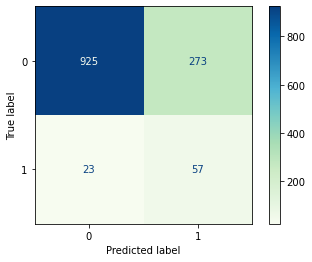

In [47]:
evaluation_report(cv_bag, X_test, y_test)

#### Model 10 

In [48]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('bag', BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, class_weight='balanced'), verbose = 1))]

bag_pipe = imbpipeline(steps=steps)
params = {
    'bag__n_estimators': range(10,20,1),
    'bag__max_samples': [.8,.85,.9,.95],
    'bag__max_features': [18,19,20],
    'bag__base_estimator__max_depth':[2,3,4]
}
cv_bag = GridSearchCV(bag_pipe, param_grid=params, scoring='precision')
cv_bag.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Us

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/imblearn/pipeline.py", line 281, in fit
    self._final_estimator.fit(Xt, yt, **fit_params)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 243, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/Users/jasonarikupurathu/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/ensemble

GridSearchCV(estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'avg_glucose_level'], dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['gender', 'hypertension', 

In [49]:
cv_bag.best_params_

{'bag__base_estimator__max_depth': 4,
 'bag__max_features': 18,
 'bag__max_samples': 0.8,
 'bag__n_estimators': 13}

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.99      0.77      0.86      3662
           1       0.14      0.82      0.24       169

    accuracy                           0.77      3831
   macro avg       0.56      0.79      0.55      3831
weighted avg       0.95      0.77      0.84      3831



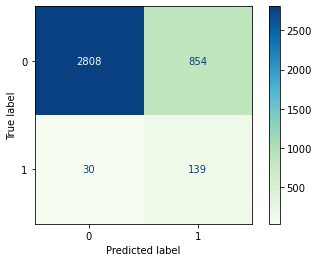

In [50]:
evaluation_report(cv_bag, X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1198
           1       0.18      0.76      0.29        80

    accuracy                           0.77      1278
   macro avg       0.58      0.77      0.58      1278
weighted avg       0.93      0.77      0.83      1278



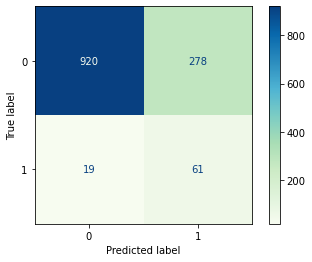

In [51]:
evaluation_report(cv_bag, X_test, y_test)

In [52]:
import xgboost

In [53]:
steps = [('trans', trans),
         ('sm', SMOTE()),
         ('xgb',xgboost.XGBClassifier())]


xgb_pipe = imbpipeline(steps=steps)

xgb_pipe.fit(X_train, y_train)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['age', 'avg_glucose_level'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_statu...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
               

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1198
           1       0.30      0.11      0.16        80

    accuracy                           0.93      1278
   macro avg       0.62      0.55      0.56      1278
weighted avg       0.90      0.93      0.91      1278



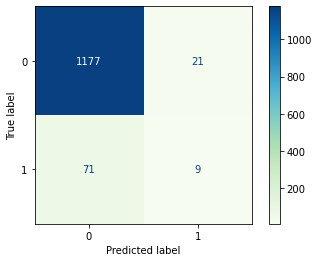

In [54]:
evaluation_report(xgb_pipe, X_test, y_test)